# Rabi experiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from qubecalib import QubeCalib
from qubecalib.neopulse import (
    Blank,
    Capture,
    Flushleft,
    Flushright,
    RaisedCosFlatTop,
    Rectangle,
    Sequence,
)

In [2]:
%matplotlib inline

In [3]:
# load the wiring settings
qc = QubeCalib("./wiring_settings.json")

In [4]:
# check the settings
qc.system_config_database.asdict()

{'clockmaster_setting': None,
 'box_settings': {'BOX1': {'ipaddr_wss': '10.1.0.73',
   'ipaddr_sss': '10.2.0.73',
   'ipaddr_css': '10.5.0.73',
   'boxtype': <Quel1BoxType.QuEL1_TypeA: ('quel-1', 'type-a')>,
   'config_root': None,
   'config_options': []}},
 'box_aliases': {},
 'port_settings': {'BOX1_READ_GEN': {'port_name': 'BOX1_READ_GEN',
   'box_name': 'BOX1',
   'port': 1,
   'ndelay_or_nwait': [0]},
  'BOX1_READ_CAP': {'port_name': 'BOX1_READ_CAP',
   'box_name': 'BOX1',
   'port': 0,
   'ndelay_or_nwait': [0, 0, 0, 0]},
  'BOX1_CTRL_0': {'port_name': 'BOX1_CTRL_0',
   'box_name': 'BOX1',
   'port': 2,
   'ndelay_or_nwait': [0, 0, 0]},
  'BOX1_CTRL_1': {'port_name': 'BOX1_CTRL_1',
   'box_name': 'BOX1',
   'port': 4,
   'ndelay_or_nwait': [0, 0, 0]},
  'BOX1_CTRL_2': {'port_name': 'BOX1_CTRL_2',
   'box_name': 'BOX1',
   'port': 9,
   'ndelay_or_nwait': [0, 0, 0]},
  'BOX1_CTRL_3': {'port_name': 'BOX1_CTRL_3',
   'box_name': 'BOX1',
   'port': 11,
   'ndelay_or_nwait': [0, 0, 0

In [5]:
# connect the box
box = qc.create_box("BOX1", reconnect=False)
if not all(box.link_status().values()):
    box.relinkup(use_204b=False, background_noise_threshold=400)
box.reconnect()

{0: True, 1: True}

In [6]:
# check the lsi settings
box.dump_box()

{'mxfes': {0: {'channel_interporation_rate': 4, 'main_interporation_rate': 6},
  1: {'channel_interporation_rate': 4, 'main_interporation_rate': 6}},
 'ports': {0: {'direction': 'in',
   'lo_freq': 8500000000,
   'cnco_freq': 1875000000.0,
   'rfswitch': 'open',
   'runits': {0: {'fnco_freq': 0.0},
    1: {'fnco_freq': 0.0},
    2: {'fnco_freq': 0.0},
    3: {'fnco_freq': 0.0}}},
  1: {'direction': 'out',
   'channels': {0: {'fnco_freq': 0.0}},
   'cnco_freq': 1875000000.0,
   'fullscale_current': 40527,
   'lo_freq': 8500000000,
   'sideband': 'U',
   'rfswitch': 'pass'},
  2: {'direction': 'out',
   'channels': {0: {'fnco_freq': 0.0},
    1: {'fnco_freq': 0.0},
    2: {'fnco_freq': 0.0}},
   'cnco_freq': 1781250000.0,
   'fullscale_current': 40527,
   'lo_freq': 9500000000,
   'sideband': 'L',
   'rfswitch': 'pass'},
  3: {'direction': 'out',
   'channels': {0: {'fnco_freq': 0.0}},
   'cnco_freq': 1500000000.0,
   'fullscale_current': 40527,
   'lo_freq': 12000000000,
   'sideband': 

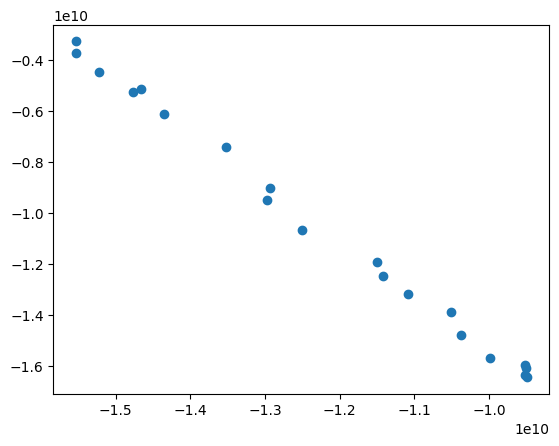

In [7]:
def rabi_sequence(duration: int) -> Sequence:
    """
    Rabi sequence with a single target.

    Parameters
    ----------
    duration : int
        Duration of the rectangle pulse in ns.

    Returns
    -------
    Sequence
        The rabi sequence.
    """
    with Sequence() as seq:
        with Flushright():
            Rectangle(
                duration=duration,
                amplitude=0.03,
            ).target("CQ00")
            Blank(duration=1024).target()
        with Flushleft():
            RaisedCosFlatTop(
                duration=1024,
                amplitude=0.1,
                rise_time=128,
            ).target("RQ00")
            Capture(duration=2 * 1024).target("RQ00")
    return seq


# add rabi sequences to the queue
sweep_range = np.arange(0, 200, 10)
for T in sweep_range:
    qc.add_sequence(rabi_sequence(T))


# execute the sequences
signals = []
for status, data, config in qc.step_execute(
    repeats=3000,
    interval=100 * 1024,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze().mean()
        signals.append(iq)
    clear_output(True)
    plt.scatter(np.real(signals), np.imag(signals))
    plt.show()

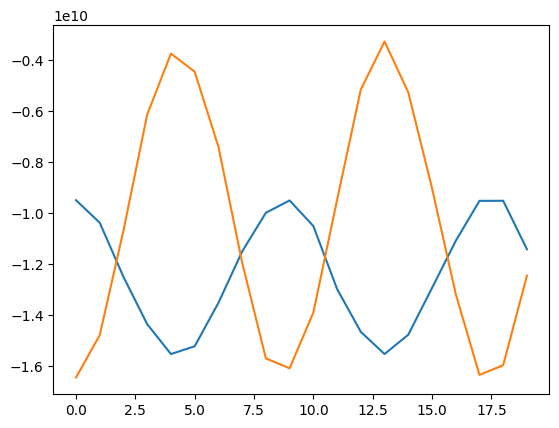

In [8]:
# plot the signals
plt.plot(np.real(signals))
plt.plot(np.imag(signals))